In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns

##### **Dataset**

In [ ]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Print dimensions
print(f"Training data dimensions: {train_images.shape}")
print(f"Testing data dimensions: {test_images.shape}")

11490434/11490434 [==============================] - 0s 0us/step
Training data dimensions: (60000, 28, 28)
Testing data dimensions: (10000, 28, 28)


It means that 60k 28x28 pictures exist in training data and 10k 28x28 pictures exist in testing (validation) data.

- display sample images:

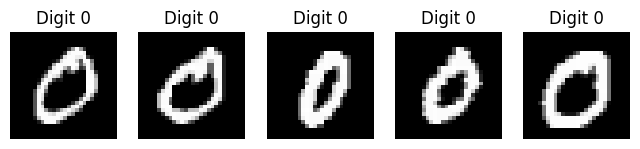

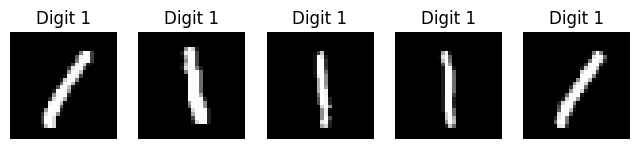

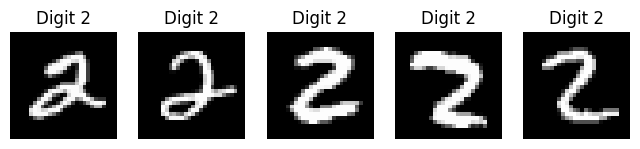

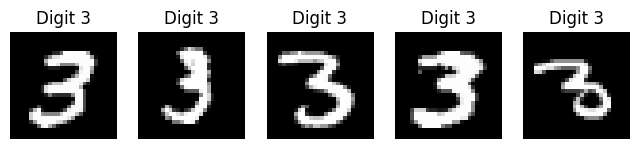

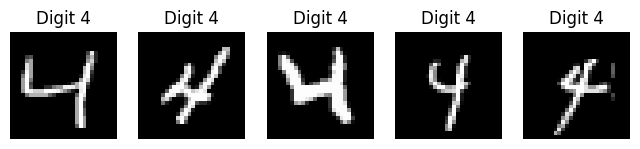

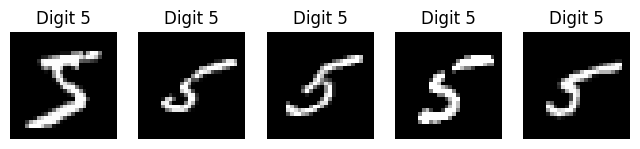

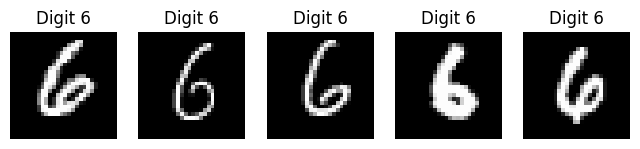

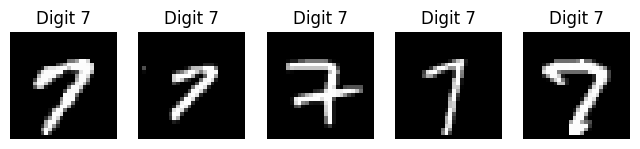

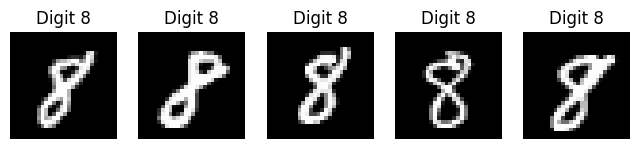

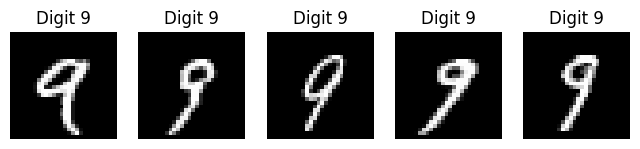

In [ ]:
# Display five images from each class
for digit in range(10):
    digit_indices = np.where(train_labels == digit)[0]
    sample_indices = digit_indices[:5]  # Get the first five samples
    plt.figure(figsize=(8, 2))
    for i, sample_index in enumerate(sample_indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(train_images[sample_index], cmap="gray")
        plt.title(f"Digit {digit}")
        plt.axis("off")

plt.show()


---

- MNIST Digit Class Distribution for training data histogram:

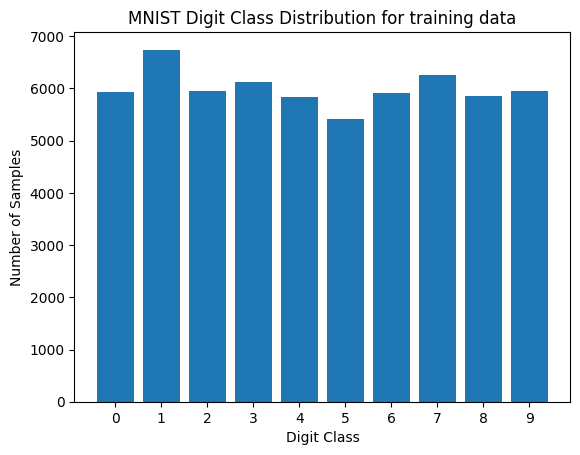

In [ ]:
# Count occurrences of each class label for training data
class_counts = np.bincount(train_labels)

# Create a bar plot
plt.bar(range(10), class_counts)
plt.xlabel("Digit Class")
plt.ylabel("Number of Samples")
plt.title("MNIST Digit Class Distribution for training data")
plt.xticks(range(10), labels=[str(i) for i in range(10)])
plt.show()


- MNIST Digit Class Distribution for testing data histogram:

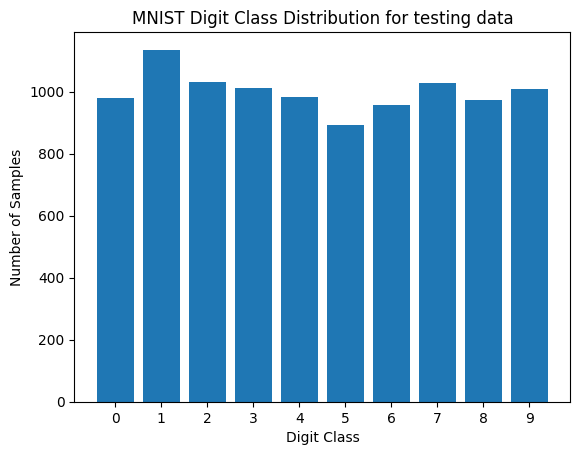

In [ ]:
# Count occurrences of each class label for testing data
class_counts = np.bincount(test_labels)

# Create a bar plot
plt.bar(range(10), class_counts)
plt.xlabel("Digit Class")
plt.ylabel("Number of Samples")
plt.title("MNIST Digit Class Distribution for testing data")
plt.xticks(range(10), labels=[str(i) for i in range(10)])
plt.show()

we don't need any process for data balancing, because the number of samples for classes is close to each other.

---

- Normalize data using `min-max normalization` to scale [0,1]

  - why we use Min-Max normalization?

  1. Enhances Model Performance: Normalized data enhances model performance and improves the accuracy of a model.

  2. Stability in Optimization Process: Normalization fosters stability in the optimization process, promoting faster convergence during gradient-based training.

  3. Easy Interpretation: Normalized data is also easy to interpret and thus, easier to understand. When all the features of a dataset are on the same scale, it also becomes easier to identify.


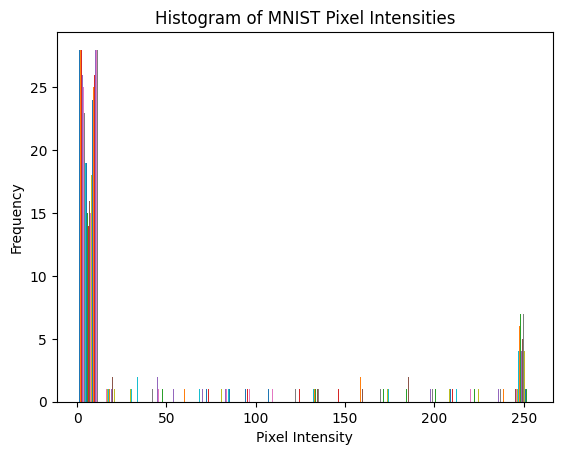

In [ ]:
# Flatten the 28x28 images into vectors of size 784
train_X_flat = train_images.reshape(-1, 784)
test_X_flat = test_images.reshape(-1, 784)

# ploting Pixel Intensity before normalization
plt.hist(train_images[0], bins=20)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Histogram of MNIST Pixel Intensities")
plt.show()


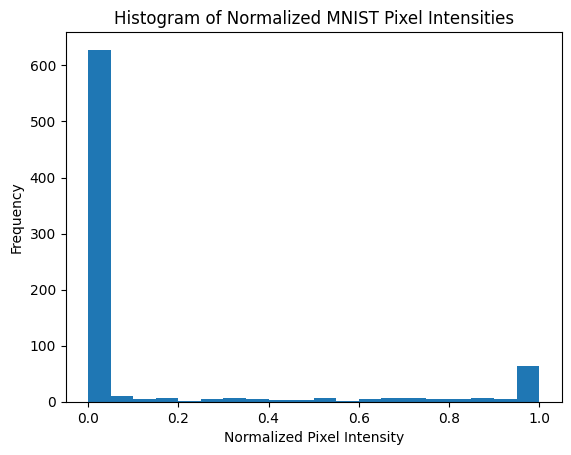

In [ ]:
# Normalize data using min-max normalization to scale [0,1]
normalized_train_X_flat = train_X_flat.astype('float32') / 255.
normalized_test_X_flat = test_X_flat.astype('float32') / 255.

# ploting Pixel Intensity after normalization
plt.hist(normalized_train_X_flat[0], bins=20, range=(0, 1))
plt.xlabel("Normalized Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Histogram of Normalized MNIST Pixel Intensities")
plt.show()

---


##### **Auto-Encoder Network**

  Input and output size of this net is 784 because $784 = 28^{2}$ (we use it for reconstructing input).

  We use `sigmoid` activation function for the last layer of decoder part to reconstructing input and `relu` for other layers.

  The loss function is `binary crossentropy` because there is 2 state for output: reconstructing in correct way or incorrect.

  We use `Adam` Optimizer because it's more common!

In [ ]:
# Define the encoder layers
input_img = Input(shape=(784,))
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(100, activation='relu')(encoded)
encoded = Dense(30, activation='relu')(encoded)

# Define the decoder layers
decoded = Dense(100, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [ ]:
# Define the autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

In [ ]:
# Train the model
history = autoencoder.fit(normalized_train_X_flat, normalized_train_X_flat,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(normalized_test_X_flat, normalized_test_X_flat))

Epoch 1/50
235/235 [==============================] - 11s 41ms/step - loss: 0.2141 - val_loss: 0.1419
Epoch 2/50
235/235 [==============================] - 11s 48ms/step - loss: 0.1264 - val_loss: 0.1140
Epoch 3/50
235/235 [==============================] - 11s 45ms/step - loss: 0.1102 - val_loss: 0.1048
Epoch 4/50
235/235 [==============================] - 10s 42ms/step - loss: 0.1032 - val_loss: 0.0997
Epoch 5/50
235/235 [==============================] - 9s 39ms/step - loss: 0.0988 - val_loss: 0.0959
Epoch 6/50
235/235 [==============================] - 11s 46ms/step - loss: 0.0958 - val_loss: 0.0938
Epoch 7/50
235/235 [==============================] - 11s 45ms/step - loss: 0.0936 - val_loss: 0.0925
Epoch 8/50
235/235 [==============================] - 11s 46ms/step - loss: 0.0920 - val_loss: 0.0907
Epoch 9/50
235/235 [==============================] - 8s 35ms/step - loss: 0.0907 - val_loss: 0.0903
Epoch 10/50
235/235 [==============================] - 11s 45ms/step - loss: 0.0897 

---

- Ploting the loss and validation loss

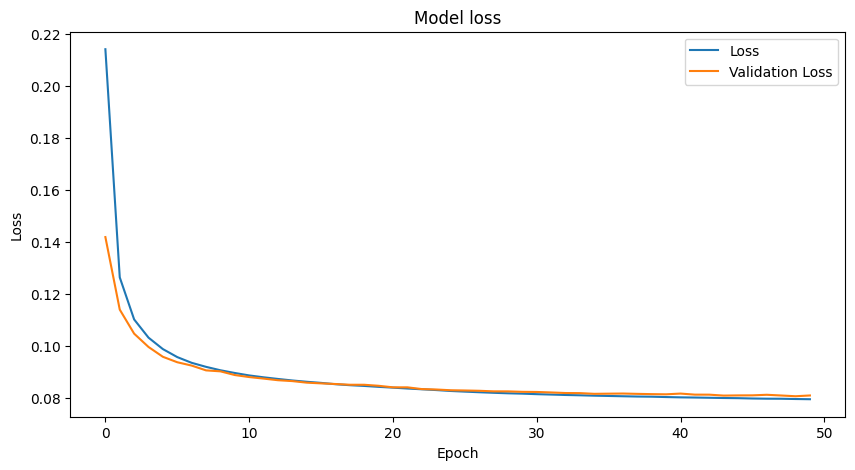

In [ ]:
# Plot the loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

As the plot shows increasing epochs didn't have tangible effect after 45 epoch.

---

##### **classifier with encoder and 2 fully connected hidden layer**

we use `softmax` activation function for output layer to obtain probability of input data being included in each class.

In [ ]:
# Create the encoder model
encoder = Model(input_img, encoded)

In [ ]:
# Use the encoder to extract the reduced features
x_train_encoded = encoder.predict(normalized_train_X_flat)
x_test_encoded = encoder.predict(normalized_test_X_flat)

313/313 [==============================] - 1s 3ms/step


In [ ]:
# Define the classifier model
input_encoded = Input(shape=(30,))
hidden = Dense(64, activation='relu')(input_encoded)
hidden = Dense(64, activation='relu')(hidden)
output = Dense(10, activation='softmax')(hidden)
classifier = Model(input_encoded, output)

In [ ]:
# Convert labels to categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

# Compile the classifier model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
history = classifier.fit(x_train_encoded, y_train,
                         epochs=50, batch_size=256, shuffle=True,
                         validation_data=(x_test_encoded, y_test))

Epoch 1/50
235/235 [==============================] - 3s 6ms/step - loss: 0.0755 - accuracy: 0.9760 - val_loss: 0.0867 - val_accuracy: 0.9727
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0729 - accuracy: 0.9772 - val_loss: 0.0870 - val_accuracy: 0.9725
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0713 - accuracy: 0.9780 - val_loss: 0.0949 - val_accuracy: 0.9702
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0706 - accuracy: 0.9777 - val_loss: 0.0919 - val_accuracy: 0.9713
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0678 - accuracy: 0.9788 - val_loss: 0.0842 - val_accuracy: 0.9730
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0679 - accuracy: 0.9787 - val_loss: 0.0794 - val_accuracy: 0.9745
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0642 - accuracy: 0.9795 - val_loss: 0.0803 - val_accuracy: 0.9750
Epoch 

---

- Plot accuracy, accuracy validation, loss and loss validation

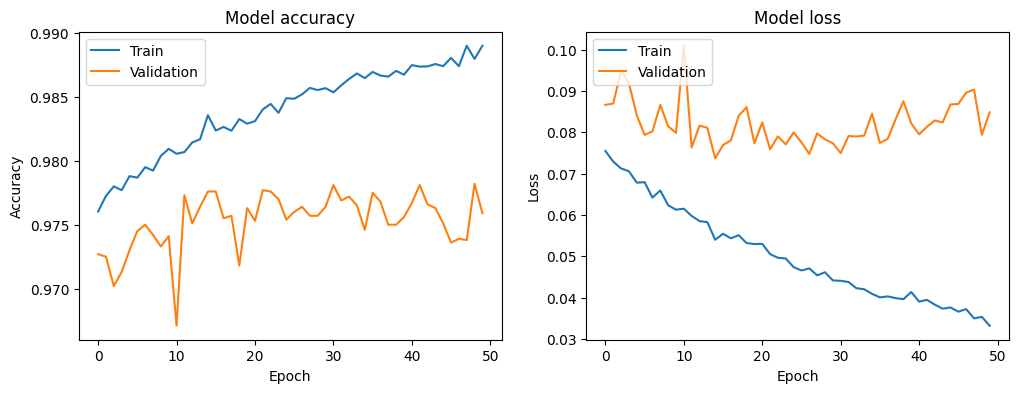

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- Report accuracy after training phase

In [ ]:
train_loss, train_acc = classifier.evaluate(x_train_encoded, y_train)
test_loss, test_acc = classifier.evaluate(x_test_encoded, y_test)
print('Accuracy:', train_acc)
print('Accuracy validation:', test_acc)

print('Loss:', train_loss)
print('Loss validation:', test_loss)

313/313 [==============================] - 1s 2ms/step - loss: 0.0848 - accuracy: 0.9759
Accuracy: 0.9891999959945679
Accuracy validation: 0.9758999943733215
Loss: 0.03307820484042168
Loss validation: 0.08484704792499542


-  confusion matrix

313/313 [==============================] - 1s 3ms/step


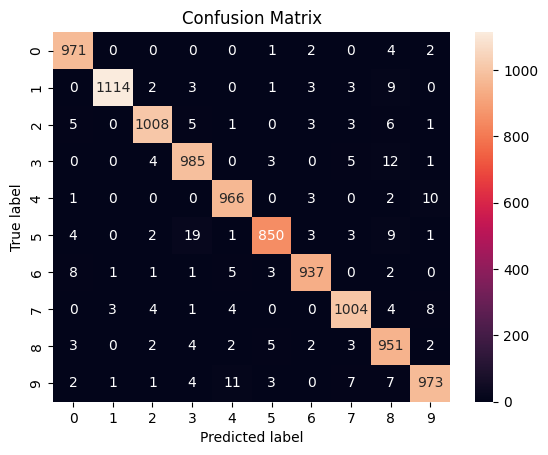

In [ ]:
y_pred = classifier.predict(x_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As it shows, the model classify the validation data with high accuracy correctly. For example `937` pictures with label `6` are classify `correctly` and 21 pictures are misclassified.